In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# -*- coding: utf-8 -*-

import sys
import copy
import numpy as np
import datetime

from matplotlib import pyplot as plt

BOXSIMU_PATH = '/home/aschi/Documents/MyPrivateRepo/boxsimu_project/'
if not BOXSIMU_PATH in sys.path:
    sys.path.append(BOXSIMU_PATH)

from boxsimu import (Fluid, Variable, Box, Flow, Condition, 
                     BoxModelSystem, Process, Reaction, Flux, Solver)
from boxsimu import utils
from boxsimu import ur
import boxsimu


#############################
# FLUIDS
#############################
# water density parameters
def get_system():
    A = 0.14395
    B = 0.0112
    C = 649.727*ur.kelvin
    D = 0.05107
    rho_expr_water = lambda time, c: A / (B**(1+(1-(c.T/C))**D))*ur.kg/ur.meter**3
    
    water = Fluid('water', rho=rho_expr_water)
    
    #############################
    # CONDITIONS
    #############################
    condition_lake = Condition(T=290*ur.kelvin, pH=5)
    condition_upper_ocean = Condition(T=280*ur.kelvin)
    condition_deep_ocean = Condition(T=275*ur.kelvin)
    
    #############################
    # VARIABLES
    #############################
    po4 = Variable('po4')
    no3 = Variable('no3')
    organic_compound1 = Variable('OC1')
    phyto = Variable('phyto')
    
    #############################
    # PROCESSES
    #############################
    process_photolytic_deg_rate = lambda t, c: -max(0,((- 10*ur.kelvin*np.cos(2*np.pi*t / (24*ur.hour))) / (10*ur.kelvin))) * 10*ur.gram/ur.hour
    process_photolytic_deg = Process(
            'Photolytic Degradation',
            organic_compound1, 
            process_photolytic_deg_rate
    ) 
    
    #############################
    # REACTIONS
    #############################
    reaction_photosynthesis = Reaction(
        name = 'Photosynthesis',
        variable_reaction_coefficients={po4: -1, no3: -7, phyto: 114},
        rate=lambda t, c: 1000 * ur.kg / ur.year
    )
    
    #############################
    # BOXES
    #############################
    lake = Box(
        name='lake',
        name_long='Medium Size Lake',
        fluid=water.q(8e4*ur.kg),
        #processes=[process_photolytic_deg,],
        reactions=[reaction_photosynthesis, ],
        variables=[po4.q(20*ur.kg),no3.q(30*ur.kg),phyto.q(30*ur.kg),], # organic_compound1],
        condition=condition_lake,
    )
    upper_ocean = Box(
        name='upper_ocean',
        name_long='Upper Ocean Box',
        fluid=water.q(3e5*ur.kg), 
        #processes=[process_photolytic_deg,],
        reactions=[reaction_photosynthesis, ],
        variables=[po4.q(30*ur.kg),no3.q(30*ur.kg),phyto.q(30*ur.kg),], # organic_compound1],
        condition=condition_upper_ocean,
    )
    deep_ocean = Box(
        name='deep_ocean',
        name_long='Deep Ocean Box', 
        fluid=water.q(20e5*ur.kg), 
        processes=[],
        reactions=[reaction_photosynthesis, ],
        variables=[po4.q(30*ur.kg),no3.q(30*ur.kg),phyto.q(30*ur.kg),], # organic_compound1],
        condition=condition_deep_ocean,
    )
    
    
    #############################
    # FLOWS
    #############################
    f1 = Flow(
        name='River flow from Lake to Ocean', 
        source_box=lake, 
        target_box=upper_ocean,
        rate=0.2e5*ur.kg/ur.hour,
    )
    f2 = Flow(
        name='Downwelling', 
        source_box=upper_ocean, 
        target_box=deep_ocean,
        rate=lambda t, c: 2.6e5*ur.kg/ur.hour, 
    )
    f3 = Flow(
        name='Upwelling',
        source_box=deep_ocean, 
        target_box=upper_ocean,
        rate=lambda t, c: 2.5e5*ur.kg/ur.hour, 
    )
    f4 = Flow(
        name='Deep Sea Percolation into Earth-Interior',
        source_box=deep_ocean, 
        target_box=None,
        rate=lambda t, c: 0.09e5*ur.kg/ur.hour, 
    )
    f5 = Flow(
        name='River inflow into lake',
        source_box=None, 
        target_box=lake,
        rate=lambda t, c: min(min(np.exp(t/(8000*ur.hour)),5)*0.1e5*ur.kg/ur.hour, 0.25e5*ur.kg/ur.hour), 
        concentrations={po4: 1e-4, no3: 2e-4, phyto: 1e-3}
    )
    
    #############################
    # FLUXES
    #############################
    
    flux1 = Flux('Biological pump', upper_ocean, deep_ocean, phyto, lambda t, c: c.box1.variables.phyto.mass * 0.1 / ur.day)
    
    
    
    #############################
    # SYSTEM
    #############################
    sys = BoxModelSystem('Test System', 
                          [lake, upper_ocean, deep_ocean], 
                          Condition(T=301.11*ur.kelvin, pH=8.3),
                          flows=[f1,f2,f3,f4,f5],
                          #fluxes=[flux1, ],
    )
    return sys


system = get_system()
solver = Solver(system) 

Start solving the flows of the box model...
- total integration time: 15000 hour
- dt (time step): 7.5 hour
10.0%
20.0%
30.0%
40.0%
50.0%
60.0%
70.0%
80.0%
90.0%
100.0%
Function "solve_flows(...)" used 24.588s


(<matplotlib.figure.Figure at 0x7f5c14f2a2e8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f5c3e9c70f0>)

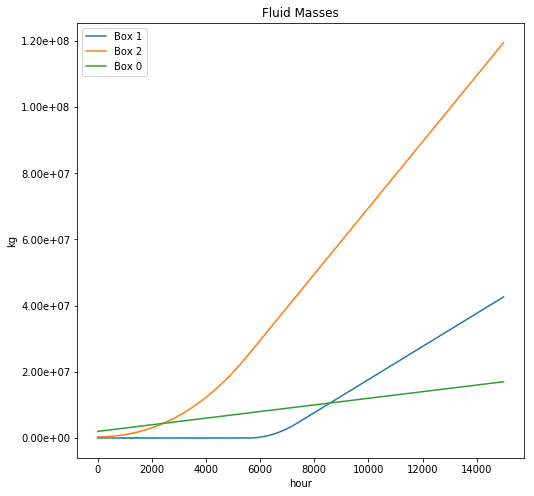

In [6]:
sol = solver.solve_flows(15000*ur.hour, 15000.0/2000*ur.hour)

(<matplotlib.figure.Figure at 0x7f5c149a4400>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f5c14a75d30>)

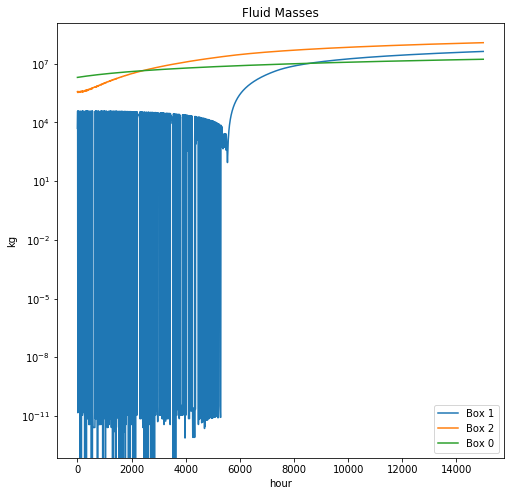

In [8]:
sol.plot_fluid_masses(yaxis_log=True)

In [5]:
import sys

sol = solver.solve(150*ur.minute, 150.0/2*ur.minute)
sol_ini = sol

Start solving the box model...
- total integration time: 150 minute
- dt (time step): 75.0 minute
> /home/aschi/Documents/MyPrivateRepo/boxsimu_project/boxsimu/solver.py(111)solve()
-> self.system = copy.deepcopy(self._system_initial)
--KeyboardInterrupt--
(Pdb) q


BdbQuit: 

In [17]:
sol = boxsimu.Solution(sol_ini.total_integration_time, sol_ini.dt, sol_ini.system)
sol.ts = sol_ini.ts
sol.time_units = sol_ini.time_units
sol.time_magnitude = sol_ini.time_magnitude
sol.time = sol_ini.time

(<matplotlib.figure.Figure at 0x7fb095c3cef0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb0956324e0>)

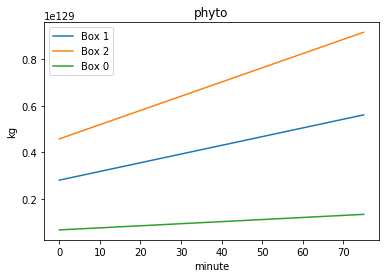

In [18]:
sol.plot_variable_mass_of_all_boxes(system.variables.phyto)